In [1]:
# This line will make sure that results are replicable

from numpy.random import seed
seed(42)
#from tensorflow import set_random_seed
#set_random_seed(42)



In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

%matplotlib inline
import sklearn
from sklearn import metrics
from sklearn.model_selection import train_test_split
import tensorflow as tf


print("libraries all imported, ready to go")

libraries all imported, ready to go


In [3]:
#Import company features
filename = 'processed_data.pkl'
feature = 'class_1'

In [4]:
pickle_in = open(filename,"rb")
df = pickle.load(pickle_in)

In [5]:
df = df.drop(['CompanyNumber'], axis=1)

In [6]:
df.head()

,MortgagesNumMortCharges,MortgagesNumMortOutstanding,MortgagesNumMortPartSatisfied,namechanged,namechanged2,class_1,MinorityScore,dAccountsOutstandingTime,dReturnsOutstandingTime,OperatingTime,...,eAccountsAccountCategory_6,eAccountsAccountCategory_7,eAccountsAccountCategory_8,eAccountsAccountCategory_9,eAccountsAccountCategory_10,eAccountsAccountCategory_11,eAccountsAccountCategory_12,eAccountsAccountCategory_13,eAccountsAccountCategory_14,eAccountsAccountCategory_15
0,0,0,0,0,0,False,0.185000,0.000000,0.917808,3.068748,...,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,False,0.809278,0.000000,1.161644,6.964923,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,True,0.011331,0.000000,0.569863,5.320548,...,0,0,0,0,0,0,0,1,0,0
3,9,4,0,0,0,False,0.024590,0.076712,0.235616,40.939726,...,0,0,0,0,0,0,0,0,1,0
4,7,7,0,0,0,False,0.045455,0.000000,1.448529,15.526027,...,0,0,0,0,0,0,0,0,1,0


In [7]:
y = df[feature].values
y.shape

(1700590,)

In [8]:
X = df.drop(feature, axis=1).values
X.shape

(1700590, 141)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [10]:
X_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [11]:
X_test_minority = X_test[np.where(X_test[:,5] >= 0.9)]

In [12]:
y_test_minority = y_test[np.where(X_test[:,5] >= 0.9)]

In [13]:
X_train_mcolumn = X_train[:,5]

#Weight companies according to function of minority score
X_train_weights1 = X_train_mcolumn
X_train_weights2 = X_train_mcolumn**2

In [14]:
#Remove minority score column from model data
X_test_minority = np.delete(X_test_minority, 5, 1)
X_train = np.delete(X_train, 5, 1)
X_test = np.delete(X_test, 5, 1)

In [15]:
X_test.shape

(510177, 140)

In [16]:
X_test_minority.shape

(6593, 140)

In [17]:
X_test_minority

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [18]:
y_test_minority

array([False,  True, False, ..., False, False, False])

In [19]:
#weighting of minority score
# Describe the architecture of the model, except for the input layer.
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation=tf.nn.relu),
    tf.keras.layers.Dense(20, activation=tf.nn.relu),
    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid),
])


# set some additional settings
model.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


In [20]:
history = model.fit(X_train, 
                    y_train, 
                    epochs=2, 
                    batch_size=512,
                    verbose=0,
                    sample_weight = X_train_weights1)

Instructions for updating:
Use tf.cast instead.


In [21]:
loss, acc = model.evaluate(X_test, y_test)
print('Loss: {:0.3f}, Accuracy: {:0.3f}'.format(loss, acc) )

510177/510177 [==============================] - 42s 82us/sample - loss: 0.2763 - acc: 0.9056
Loss: 0.276, Accuracy: 0.906


In [22]:
loss, acc = model.evaluate(X_test_minority, y_test_minority)
print('Loss: {:0.3f}, Accuracy: {:0.3f}'.format(loss, acc) )

6593/6593 [==============================] - 1s 109us/sample - loss: 0.3813 - acc: 0.8488
Loss: 0.381, Accuracy: 0.849


In [23]:
y_pred = model.predict(X_test)

In [24]:
y_pred_minority = model.predict(X_test_minority)

In [25]:
#get false positive rate, true positive rate, area under curve
fpr1, tpr1, _ = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.roc_auc_score(y_test, y_pred)

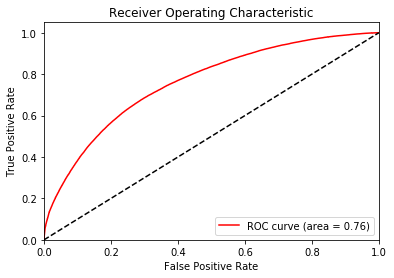

In [26]:
plt.figure()
plt.plot(fpr1, tpr1, color='red', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [27]:
fpr2, tpr2, _ = metrics.roc_curve(y_test_minority, y_pred_minority)
roc_auc1 = metrics.roc_auc_score(y_test_minority, y_pred_minority)

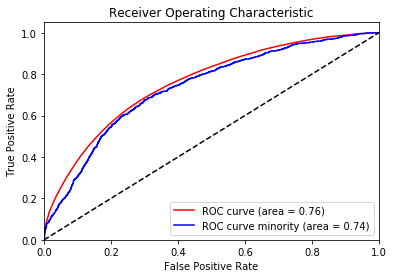

In [28]:
plt.figure()
plt.plot(fpr1, tpr1, color='red', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot(fpr2, tpr2, color='blue', label='ROC curve minority (area = %0.2f)' % roc_auc1)
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [29]:
#weighting of minority score squared
# Describe the architecture of the model, except for the input layer.
model2 = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation=tf.nn.relu),
    tf.keras.layers.Dense(20, activation=tf.nn.relu),
    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid),
])


# set some additional settings
model2.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [32]:
history = model2.fit(X_train, 
                    y_train, 
                    epochs=2, 
                    batch_size=512,
                    verbose=0,
                    sample_weight = X_train_weights2)

In [33]:
loss, acc = model2.evaluate(X_test, y_test)
print('Loss: {:0.3f}, Accuracy: {:0.3f}'.format(loss, acc) )

510177/510177 [==============================] - 38s 75us/sample - loss: 0.2788 - acc: 0.9046
Loss: 0.279, Accuracy: 0.905


In [34]:
loss, acc = model2.evaluate(X_test_minority, y_test_minority)
print('Loss: {:0.3f}, Accuracy: {:0.3f}'.format(loss, acc) )

6593/6593 [==============================] - 1s 87us/sample - loss: 0.3788 - acc: 0.8538
Loss: 0.379, Accuracy: 0.854


In [35]:
y_pred = model2.predict(X_test)

In [36]:
y_pred_minority = model2.predict(X_test_minority)

In [37]:
fpr1, tpr1, _ = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.roc_auc_score(y_test, y_pred)

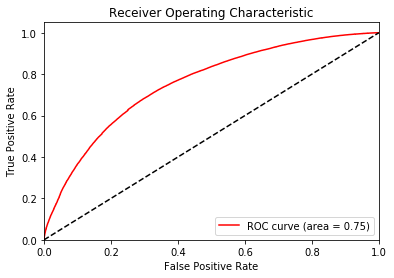

In [38]:
plt.figure()
plt.plot(fpr1, tpr1, color='red', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [39]:
fpr2, tpr2, _ = metrics.roc_curve(y_test_minority, y_pred_minority)
roc_auc1 = metrics.roc_auc_score(y_test_minority, y_pred_minority)

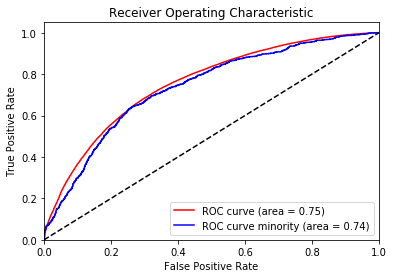

In [40]:
plt.figure()
plt.plot(fpr1, tpr1, color='red', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot(fpr2, tpr2, color='blue', label='ROC curve minority (area = %0.2f)' % roc_auc1)
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()